In [1]:
# read parquet file
import pandas as pd
import pyarrow.parquet as pq
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs.Utils import CosineSimilarity
from sklearn.metrics import f1_score
from rdkit.DataStructs import TanimotoSimilarity

In [21]:
#df = pd.read_parquet('data/enveda_chemist_annotations_hackathon.parquet.pq')
# read pandas from pickle
df = pd.read_pickle('../data/valid_df.pkl')

In [22]:
# remove rows where unable_to_assess is 1
df = df[df['unable_to_assess'] == 0]

# represent ground truth smiles and predicted smiles as ECFP4 fingerprints
df['ground_truth_mol'] = df['ground_truth_smiles'].apply(Chem.MolFromSmiles)
df['predicted_mol'] = df['predicted_smiles'].apply(Chem.MolFromSmiles)

fpgen = AllChem.GetMorganGenerator(radius=2)
df['ground_truth_fp'] = df['ground_truth_mol'].apply(lambda x: fpgen.GetFingerprint(x))
df['predicted_fp'] = df['predicted_mol'].apply(lambda x: fpgen.GetFingerprint(x))

In [23]:
# calculate cosine similarity between ground truth and predicted fingerprints
similarity = df.apply(lambda x: CosineSimilarity(x['ground_truth_fp'], x['predicted_fp']), axis=1)
#similarity = df.apply(lambda x: TanimotoSimilarity(x['ground_truth_fp'], x['predicted_fp']), axis=1)
# add 4 columns to the dataframe to store the 4 quartiles (not_close_match, close_match, near_exact_match, exact_match)
df['predicted_not_close_match'] = (similarity < 0.25).astype(int)
df['predicted_close_match'] = ((similarity >= 0.25) & (similarity < 0.5)).astype(int)
df['predicted_near_exact_match'] = ((similarity >= 0.5) & (similarity < 0.75)).astype(int)
df['predicted_exact_match'] = (similarity >= 0.75).astype(int)
# save the 4 quartiles as a single column with the values: 1 for not_close_match, 2 for close_match, 3 for near_exact_match, 4 for exact_match
df['predicted_match'] = df['predicted_not_close_match'] + 2*df['predicted_close_match'] + 3*df['predicted_near_exact_match'] + 4*df['predicted_exact_match']

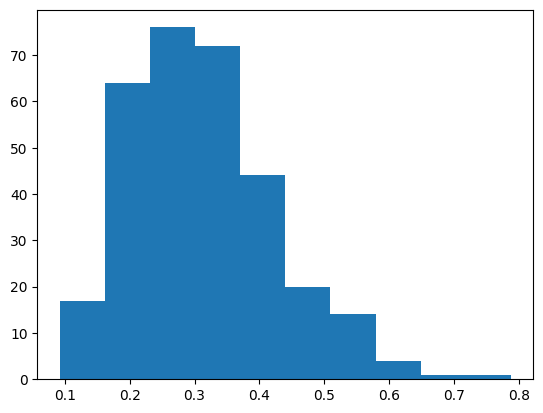

0.09243602319653889 0.7876164542310643


In [24]:
import matplotlib.pyplot as plt
plt.hist(similarity, bins=10)
plt.show()
print(min(similarity), max(similarity))

In [25]:

df["not_close_match"] = df["not_close_match"].astype(int)
df["close_match"] = df["close_match"].astype(int)
df["near_exact_match"] = df["near_exact_match"].astype(int)
df["exact_match"] = df["exact_match"].astype(int)

df["ground_truth_match"] = df['not_close_match'] + 2*df['close_match'] + 3*df['near_exact_match'] + 4*df['exact_match']

In [26]:
# calculate weighted f1 score
f1 = f1_score(df['ground_truth_match'], df['predicted_match'], average='weighted')
print(f'Weighted F1 score: {f1}')

Weighted F1 score: 0.38762384043351933
